## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [347]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from skimage import io
from tensorflow.keras.regularizers import l2
from glob import glob

In [348]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [349]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin_cancer/Train")
data_dir_test = pathlib.Path('Skin_cancer/Test')

In [350]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [351]:
batch_size = 32
img_height = 180
img_width = 180
#class_names = ['vascular lesion','squamous cell carcinoma','seborrheic keratosis','pigmented benign keratosis','nevus',
#               'melanoma','dermatofibroma','basal cell carcinoma','actinic keratosis']

Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [353]:
## Write your train and validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names = None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    #,**kwargs
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [354]:
#Creating test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    class_names = None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    #,**kwargs
)

Found 118 files belonging to 9 classes.


In [355]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
train_class_names = train_ds.class_names
print(train_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [356]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 9)


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

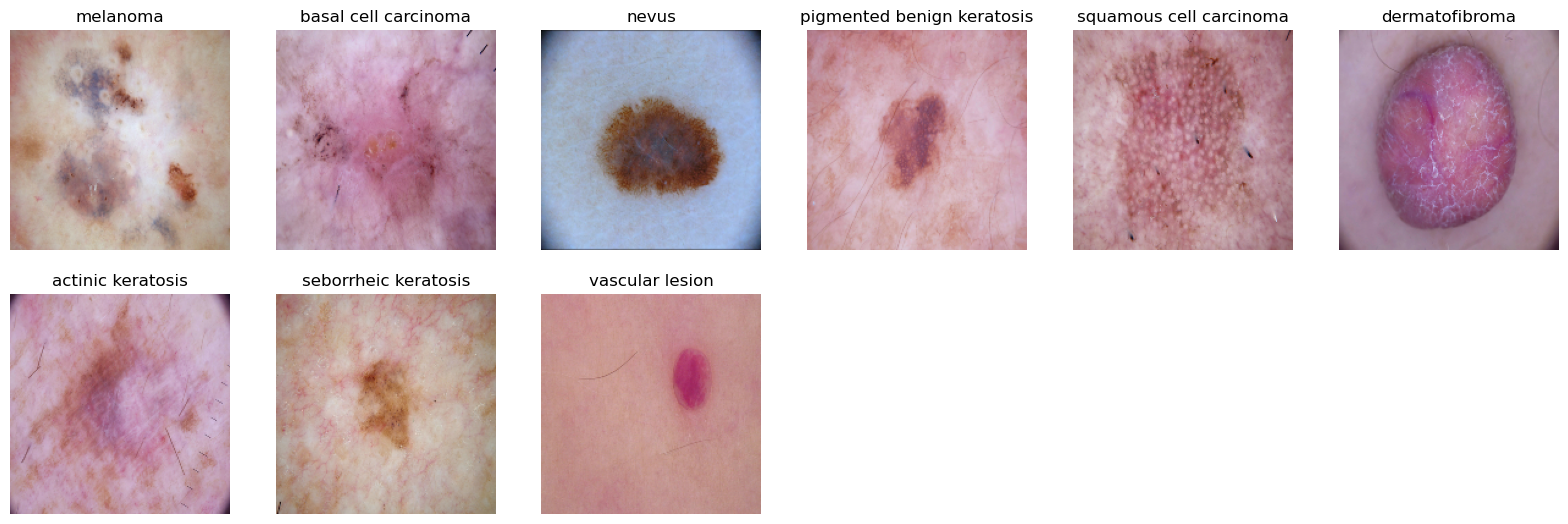

In [359]:
### your code goes here, you can use training or validation data to visualize
### To visualize the images
plt.figure(figsize=(20, 20))
#plt.suptitle('displaying one image of each category in train set'.upper(), y= 1.0, fontsize= 16)
i = 0
filtered_images = []
j = 0
for images, labels in train_ds.take(1792):
    j = j+1
    #print(images[0][0])
    #print(labels[0])
    if np.argmax(labels[0]) not in filtered_images:
        filtered_images.extend([np.argmax(labels[0])])
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(train_class_names[np.argmax(labels[0])])
        plt.axis("off")
        i = i + 1
    #print("J=",j,"(",filtered_images,")",",","I=",i)
    if len(filtered_images) == len(train_class_names):
        break
    
# Plotting the images
plt.show()
#print(i)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [360]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Standardizing values to be in the `[0, 1]`

In [361]:
num_classes = len(train_class_names)
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [362]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Train the model

In [364]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 111s 2s/step - loss: 2.0314 - accuracy: 0.2483 - val_loss: 1.8503 - val_accuracy: 0.3893
Epoch 2/20
56/56 [==============================] - 86s 2s/step - loss: 1.7379 - accuracy: 0.3683 - val_loss: 1.6642 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 48s 853ms/step - loss: 1.5756 - accuracy: 0.4364 - val_loss: 1.5127 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 28s 497ms/step - loss: 1.4513 - accuracy: 0.4866 - val_loss: 1.4279 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 29s 513ms/step - loss: 1.3955 - accuracy: 0.5128 - val_loss: 1.3875 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 32s 568ms/step - loss: 1.3376 - accuracy: 0.5262 - val_loss: 1.7588 - val_accuracy: 0.3736
Epoch 7/20
56/56 [==============================] - 32s 563ms/step - loss: 1.2879 - accuracy: 0.5357 - val_loss: 1.3361 - val_accuracy: 0.5280
Epoc

In [368]:
# View the summary of all layers
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 43, 43, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 41, 41, 32)      

### Visualizing training results

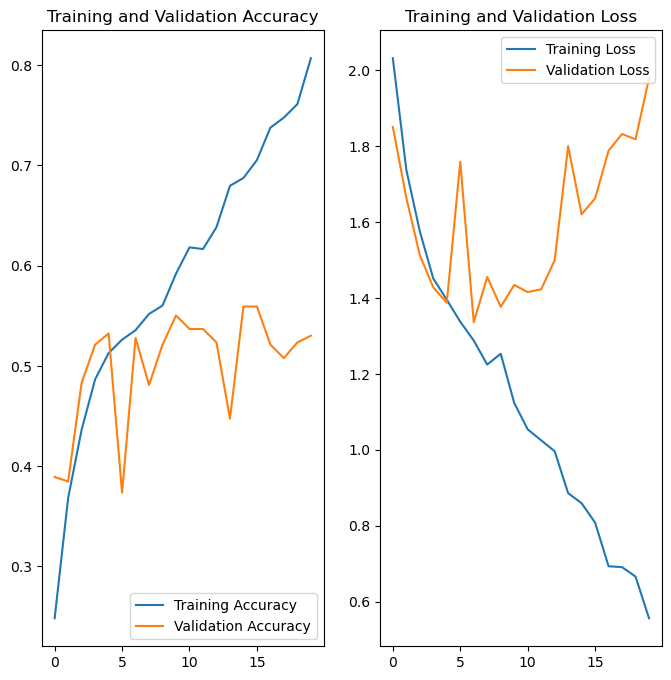

In [365]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We have got accuracy on the training set is 80% and on validation set it is 53%. From this result we can confirm that there is a problem of overfitting.

### Lets now use some data augmentation strategy like random flip and random rotation to handle overfitting

In [366]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


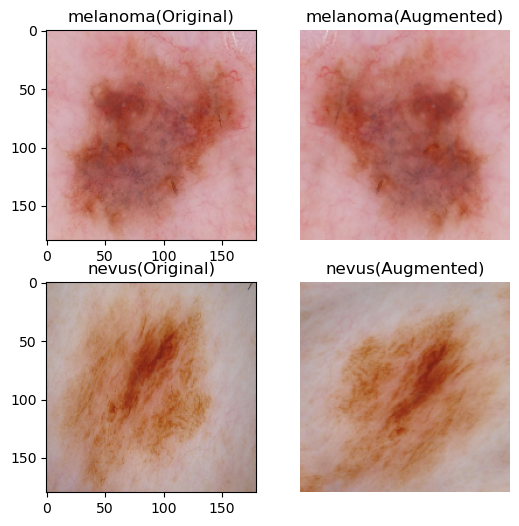

In [338]:
# visualize how your augmentation strategy works for training image.
plt.figure(figsize=(6, 6))
i = 0
for images, labels in train_ds.take(2):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    org_image = train_class_names[np.argmax(labels[0])] + "(Original)"
    plt.title(org_image)
    i = i + 1
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    aug_image = train_class_names[np.argmax(labels[0])] + "(Augmented)"
    plt.title(aug_image)
    plt.axis("off")
    i = i + 1
    
# Plotting the images
plt.show()

In [367]:
#applying data augmentation strategy for training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

### Lets create the model with batch nornalization layer and dropout layer, compile and train the model


In [369]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, kernel_regularizer=l2(0.01), activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [370]:
model2.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [371]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 38s 617ms/step - loss: 3.8228 - accuracy: 0.3694 - val_loss: 4.0823 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 38s 678ms/step - loss: 3.1808 - accuracy: 0.4470 - val_loss: 3.9538 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 40s 708ms/step - loss: 2.7901 - accuracy: 0.4738 - val_loss: 4.2213 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 41s 728ms/step - loss: 2.4831 - accuracy: 0.4927 - val_loss: 3.4063 - val_accuracy: 0.1521
Epoch 5/20
56/56 [==============================] - 34s 602ms/step - loss: 2.2308 - accuracy: 0.5078 - val_loss: 3.4632 - val_accuracy: 0.1544
Epoch 6/20
56/56 [==============================] - 44s 782ms/step - loss: 2.0346 - accuracy: 0.5179 - val_loss: 3.3232 - val_accuracy: 0.1902
Epoch 7/20
56/56 [==============================] - 49s 864ms/step - loss: 1.8759 - accuracy: 0.5324 - val_loss: 2.8111 - val_accuracy: 0.2595

In [372]:
# View the summary of all layers
print(model2.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 90, 90, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_65 (Conv2D)          (None, 88, 88, 32)        9248      
                                                                 
 batch_normalization_35 (Ba  (None, 88, 88, 32)      

### Visualizing the results

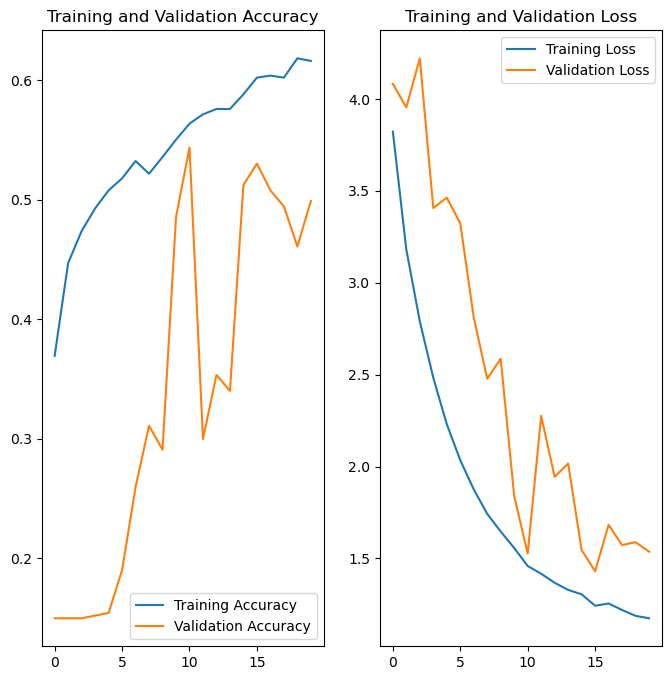

In [373]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We have tried the the data augmentation strategy with training dataset. Now training accuracy is 61% and validation accuracy is 49%. Overfitting has been reduced a bit but since training accuracy is dropped which show the signs of underfitting too.

#### Lets find the class distribution of classes to find the class imbalance.

In [449]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
len(path_list_old)

2239

In [450]:
lesion_list_old = [os.path.basename(os.path.dirname((y))) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]
len(lesion_list_old)

2239

In [451]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [452]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [453]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [480]:
original_df['Label'].value_counts(normalize = True)

pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
Name: Label, dtype: float64

#### From above analysis we can confirm that there is a class imbalance.
#### - Class `seborrheic keratosis` has the least no of samples as 77 samples i.e (3.43%) of total samples.
#### - Class `pigmented benign keratosis`, `melanoma`, `basal cell carcinoma` dominates the dataset with 462 (20.63%), 438 (19.56%) and 376 (16.79%) samples respectively from total 2239 samples.

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [149]:
#pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [269]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    print(i)
    output_path = str(path_to_training_dataset) + "/" + str(i)
    p = Augmentor.Pipeline(output_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin_cancer\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x29479072530>: 100%|█| 500/500 [00:19<00:00, 25.31 Samples/


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin_cancer\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x294563F6830>: 100%|█| 500/500 [00:20<00:00, 24.14 Samples/


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin_cancer\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x294CD519120>: 100%|█| 500/500 [00:37<00:00, 13.37 Samples


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin_cancer\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x294E82350F0>: 100%|█| 500/500 [00:20<00:


nevus
Initialised with 357 image(s) found.
Output directory set to Skin_cancer\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=957x723 at 0x294905B2620>: 100%|█| 500/500 [01:18<00:00,  6.36 Samples/


melanoma
Initialised with 438 image(s) found.
Output directory set to Skin_cancer\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2949069A770>: 100%|█| 500/500 [01:43<00:00,  4.84 Samples


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin_cancer\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x294E82361A0>: 100%|█| 500/500 [00:20<00:00, 23.96 Samples/


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin_cancer\Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x29456445330>: 100%|█| 500/500 [00:20<00:


actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin_cancer\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x294905B0760>: 100%|█| 500/500 [00:21<00:00, 23.47 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [458]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [459]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [460]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [461]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\Vaibhav Kumthekar\AppData\Local\Temp\ipykernel_23524\390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [462]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [481]:
new_df['Label'].value_counts(normalize = True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

#### - Class `seborrheic keratosis` has 577 samples i.e (8.56%) of total samples.
#### - Classes `pigmented benign keratosis`, `melanoma`, `basal cell carcinoma` has 962 (14.27%), 938 (13.91%) and 876 (12.99%) samples respectively from total 6739 samples.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [296]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training and validation dataset

In [318]:
#data_dir_train=data_dir_train
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names = None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    #,**kwargs
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [319]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.25),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, kernel_regularizer=l2(0.01), activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [320]:
model3.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [321]:
epochs = 30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 146s 821ms/step - loss: 3.3747 - accuracy: 0.3657 - val_loss: 3.9354 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 146s 860ms/step - loss: 2.3625 - accuracy: 0.4436 - val_loss: 3.2761 - val_accuracy: 0.1388
Epoch 3/30
169/169 [==============================] - 152s 897ms/step - loss: 1.8277 - accuracy: 0.4948 - val_loss: 2.2311 - val_accuracy: 0.2851
Epoch 4/30
169/169 [==============================] - 150s 882ms/step - loss: 1.5334 - accuracy: 0.5358 - val_loss: 1.8518 - val_accuracy: 0.4053
Epoch 5/30
169/169 [==============================] - 147s 865ms/step - loss: 1.3486 - accuracy: 0.5797 - val_loss: 1.8235 - val_accuracy: 0.4246
Epoch 6/30
169/169 [==============================] - 147s 868ms/step - loss: 1.1938 - accuracy: 0.6074 - val_loss: 1.0923 - val_accuracy: 0.6414
Epoch 7/30
169/169 [==============================] - 149s 880ms/step - loss: 1.0757 - accuracy: 0.6545 - val_loss: 1.0774 -

#### **Todo:**  Visualize the model results

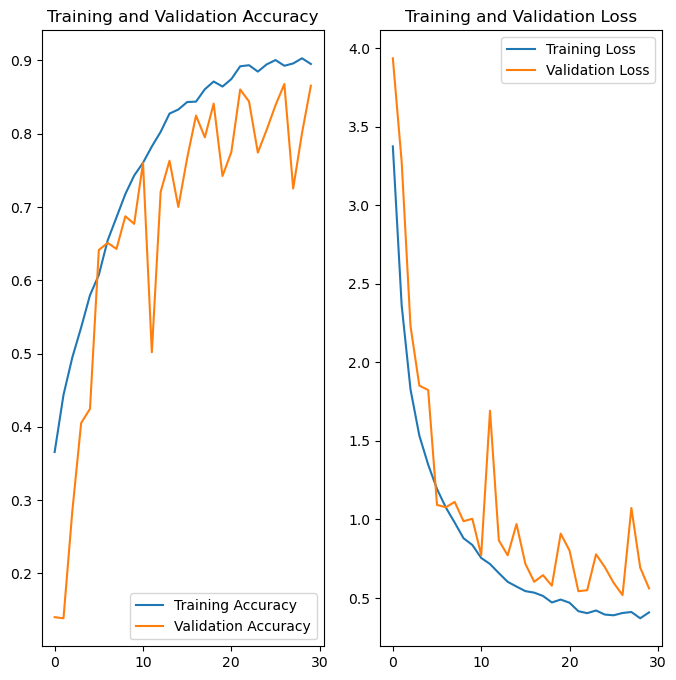

In [322]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### From above results we can see that training accuracy is 89% and validation accuracy is 86%. We have handled the overfitting with data augmentation strategy and class balancing.

#### Checking accuracy on test dataset

In [465]:
model3.evaluate(
    x=test_ds,
    verbose='auto',
    max_queue_size=10,
    workers=1,
    #**kwargs
)

4/4 [==============================] - 6s 494ms/step - loss: 2.8529 - accuracy: 0.4576


[2.8529391288757324, 0.4576271176338196]

In [464]:
#Prediction on test dataset
model3.predict(test_ds, verbose=2).argmax(axis=1)

4/4 - 3s - 3s/epoch - 776ms/step


array([4, 0, 5, 3, 0, 6, 4, 3, 2, 1, 5, 3, 5, 5, 4, 3, 4, 2, 4, 1, 6, 5,
       4, 0, 4, 8, 4, 1, 4, 5, 0, 5, 5, 3, 5, 0, 5, 4, 4, 4, 3, 4, 6, 2,
       3, 4, 5, 3, 3, 5, 3, 3, 8, 7, 5, 2, 5, 6, 5, 5, 0, 4, 3, 5, 3, 4,
       5, 5, 4, 4, 3, 3, 5, 5, 4, 8, 5, 4, 4, 5, 4, 5, 5, 2, 1, 1, 1, 1,
       4, 5, 2, 5, 7, 7, 4, 3, 5, 2, 5, 1, 5, 3, 1, 2, 3, 5, 1, 5, 5, 4,
       4, 5, 4, 5, 4, 2, 7, 4], dtype=int64)